In [1]:
import os
import numpy as np
import pandas as pd
import pystan
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline
import corner
import random

load csv files on ESA vo space

In [2]:
lensedQSO = pd.read_csv("http://vospace.esac.esa.int/vospace/sh/baf64b11fe35d35f18879b1d292b0c4b02286a?dl=1")
allwiseQSO = pd.read_csv("http://vospace.esac.esa.int/vospace/sh/d18d69255b40f4178ec5155a679a33e1dbddd37?dl=1")

In [3]:
lensedQSO.head()

,qso_name,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,pmra_pmdec_corr,astrometric_pseudo_colour,astrometric_pseudo_colour_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
0,HE0047-1756,2369490546185699328,12.615931,0.076388,-17.669214,0.058220,0.097698,0.092577,1.055309,0.076398,0.158129,-0.006803,0.109641,0.301177,1.620292,0.012361,16.563572,16.620966,15.937707
1,HE0047-1756,2369490546185041280,12.615999,0.189386,-17.669605,0.140448,-0.682476,0.231477,-2.948348,-0.330528,0.403409,-0.110292,0.265450,0.305382,1.618917,0.030294,18.164522,NaN,NaN
2,Q0142-100,2464353656357088512,26.319754,0.370413,-9.754967,0.286754,-0.939707,0.451564,-2.081003,-2.224273,0.917841,-1.664971,0.481138,0.109713,1.444181,0.091909,18.988495,18.913712,18.060420
3,Q0142-100,2464353660650971520,26.319149,0.083420,-9.754796,0.064728,-0.044349,0.100954,-0.439300,0.176229,0.203407,0.319330,0.117240,0.175879,1.653217,0.021742,16.824093,17.006912,16.412447
4,QJ0158-4325,4956574748449686272,29.672640,0.078830,-43.417683,0.085769,-0.534137,0.116365,-4.590196,-0.931296,0.152795,2.149305,0.173318,-0.244111,1.679776,0.021640,17.603382,17.448757,16.989534


In [4]:
allwiseQSO.head()

,qso_id,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,pmra_pmdec_corr,astrometric_pseudo_colour,astrometric_pseudo_colour_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
0,4464193611667355648,4464193611667355648,243.260471,0.201364,13.305277,0.168122,0.246102,0.257234,0.956725,0.315580,0.403400,-0.498414,0.314645,0.390461,1.584570,0.052428,18.961899,18.983690,18.139938
1,5781870989465777280,5781870989465777280,234.201062,0.194706,-75.363654,0.197216,-0.115579,0.259315,-0.445710,0.231683,0.350220,-0.409597,0.434596,0.279378,1.615388,0.053050,18.896204,19.242865,18.356125
2,4464219042171552640,4464219042171552640,243.087440,0.225273,13.647291,0.185492,0.026417,0.302170,0.087426,-0.136931,0.455150,-0.489338,0.348707,0.509504,1.731374,0.060620,19.170952,19.266823,18.767769
3,6680760094932026624,6680760094932026624,306.840993,0.444380,-40.154422,0.389749,0.502715,0.574393,0.875212,-0.619293,0.833314,-0.908358,0.743498,0.235555,1.596177,0.119878,19.880201,20.381166,19.070530
4,5781825359732466304,5781825359732466304,238.236096,0.522872,-75.318353,0.451941,0.610903,0.559800,1.091288,-1.526021,0.880340,-1.167647,0.900178,0.370891,1.675655,0.128900,20.121286,20.420282,19.594530


Here we restrict to a random sample of the allwise QSOs to speed up the computation. The results might change slightly according to the selected sample.

In [7]:
lqsoNew = lensedQSO[np.isfinite(lensedQSO['pmra'])].copy()
qsoNew = allwiseQSO[np.isfinite(allwiseQSO['pmra'])].sample(n=len(lqsoNew)).copy()

In [8]:
def sigma2(ea,ed,c) : 
    """ the largest eigen value of the covariance matrix defined by
    ea : right ascention error
    ed : declination error
    c  : correlation
    """
    res = np.power(ea,2) + np.power(ed,2) 
    res = res + np.sqrt(np.power(ea-ed,2) + np.power(2*ea*ed*c,2))
    return res/2

def setMu(d):
    """
    set mu, mu_error and mu_norm taking in account the correlation
    """
    d['mu'] = np.sqrt(np.power(d.pmra,2)+np.power(d.pmdec,2))
    d['mu_error'] = np.sqrt(sigma2(d.pmra_error,d.pmdec_error,d.pmra_pmdec_corr))
    d['mu_over_error'] = d.mu/d.mu_error

In [9]:
setMu(lqsoNew)
setMu(qsoNew)

# Model 1 
A model to compare the distribution of the proper motion assuming a log normal distribution.

In [10]:
Nl = len(lqsoNew)
Nq = len(qsoNew)

In [11]:
bayesmod1 = """
data{
    int<lower=0> Nq; //number of quasars
    int<lower=0> Nl; //number of lens
    vector[Nq] muqhat; //propermotion of qso
    vector[Nl] mulhat; //propermotion of lens
    vector<lower=0>[Nq] sigq; //error on pm of qso
    vector<lower=0>[Nl] sigl; //error on pm of lens
}

parameters{
    //population parameters
    real mu1;
    real mu2;   
    real<lower=0> sigma1;
    real<lower=0> sigma2;
    vector<lower=0>[Nq] muq; //propermotion of qso
    vector<lower=0>[Nl] mul; //propermotion of lens
}

model{
    // prior
    mu1 ~ normal(0,1); 
    mu2 ~ normal(0,1); 
    sigma1 ~ normal(0,1);
    sigma2 ~ normal(0,1);

    //likelihood
    muqhat ~ normal(muq, sigq);  
    mulhat ~ normal(mul, sigl);  

    muq ~ lognormal(mu1, sigma1);
    mul ~ lognormal(mu2, sigma2);
}
"""

In [12]:
mixedData = {
    'Nq': Nq,
    'Nl': Nl,
    'muqhat': qsoNew.mu,
    'mulhat': lqsoNew.mu,
    'sigq': qsoNew.mu_error,
    'sigl': lqsoNew.mu_error
}

In [13]:
sm1 = pystan.StanModel(model_code=bayesmod1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34e24fecc14af65df3539389154d0073 NOW.


In [14]:
fit1 = sm1.sampling(data=mixedData, iter=1000, chains=1) # Could be run for longer, but 1 chain at 1000 samples takes ~4hrs

/Users/abombrun/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [15]:
params=fit1.extract()

In [16]:
mu1=params['mu1']
mu2=params['mu2']
sigma1=params['sigma1']
sigma2=params['sigma2']

In [17]:
pop_params = np.vstack([mu1,mu2,sigma1,sigma2])

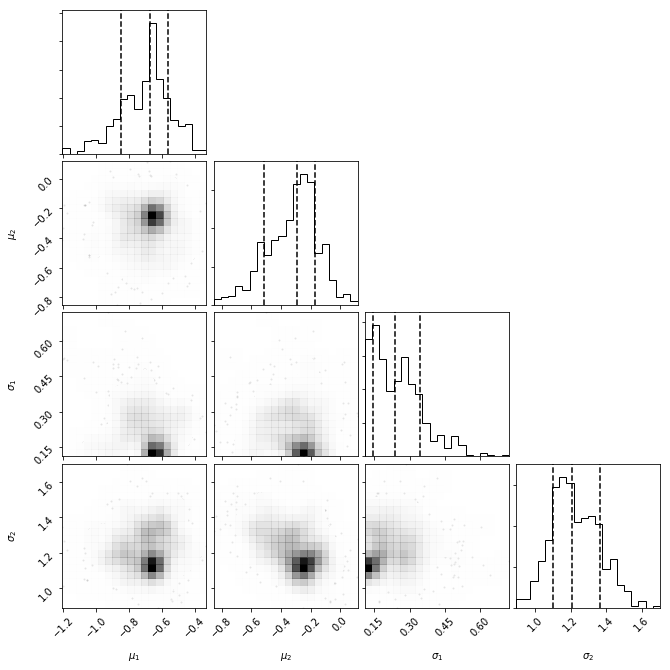

In [18]:
fig = corner.corner(pop_params.T, 
                labels=[r"$\mu_1$", r"$\mu_2$", r"$\sigma_1$", r"$\sigma_2$"],
                quantiles=[0.16, 0.5, 0.84],
                plot_contours=False, smooth=True)

In [19]:
print('mu lqso: ', round(np.mean(mu1),2),'+/-', round(np.std(mu1),2))
print('mu qso: ', round(np.mean(mu2),2), '+/-', round(np.std(mu2),2))
print('sigma lqso: ', round(np.mean(sigma1),2),'+/-', round(np.std(sigma1),2))
print('sigma qso: ', round(np.mean(sigma2),2), '+/-', round(np.std(sigma2),2))

mu lqso:  -0.7 +/- 0.15
mu qso:  -0.32 +/- 0.17
sigma lqso:  0.25 +/- 0.11
sigma qso:  1.23 +/- 0.13


# Model 2 
A model to compare the distribution of the proper motion vectors using normal prior and multi normal distribution to fully use Gaia likelihood.

In [20]:
bayesmod2 = """
data{
    int<lower=0> N; //number of objects
    row_vector[2] pmhat[N]; //propermotion observed
    cov_matrix[2] Sig[N]; //error on propermotion
}

parameters{
    //population parameters
    row_vector[2] mu;
    row_vector<lower=0>[2] sigma;
    row_vector[2] pm[N]; //true propermotion
}

model{
    //priors on hyper params
    mu ~ normal(0,1);
    sigma ~ normal(0,1);


    //observed proper motions
    for(n in 1:N){
        pm[n] ~ normal(mu, sigma);
        pmhat[n] ~ multi_normal(pm[n], Sig[n]);
    }
}
"""


In [21]:
sm2 = pystan.StanModel(model_code=bayesmod2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_df0098f6db9784cae5cf50f026da1b15 NOW.


## Test with toy data

In [22]:
#make some toy data
Nq = 100 #number of quasar
Nl = 100 #number of lens

muq = [-0.1,-0.1]#population parameters 
mul = [0.3,0.4] 
sigq = np.reshape([0.02**2,0,0,0.01**2],[2,2])
sigl = np.reshape([0.06**2,0,0,0.05**2],[2,2])

Sigmaq = np.reshape([0.01**2,0,0,0.01**2],[2,2])#observational uncertainty covariance matrix
Sigmal = np.reshape([0.03**2,0,0,0.04**2],[2,2]) 

#observed proper mootions
pmq = np.empty([Nq, 2])
pmqhat = np.empty([Nq, 2])
for iq in np.arange(Nq):
    pmq[iq, :] = np.random.multivariate_normal(muq, sigq)
    pmqhat[iq,:] = np.random.multivariate_normal(pmq[iq], Sigmaq)

pml = np.empty([Nl, 2])
pmlhat = np.empty([Nl, 2])
for il in np.arange(Nl):
    pml[il, :] = np.random.multivariate_normal(mul, sigl)
    pmlhat[il,:] = np.random.multivariate_normal(pml[il], Sigmal)


In [23]:
qsodata={
    'N': Nq,
    'pmhat': pmqhat,
    'Sig': np.dstack([[Sigmaq]*Nq]),
}

In [24]:
fitqso = sm2.sampling(data=qsodata, init='random', iter=2000, chains=1) 

/Users/abombrun/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [25]:
lqsodata={
    'N': Nl,
    'pmhat': pmlhat,
    'Sig': np.dstack([[Sigmal]*Nl]),
}

fitlqso = sm2.sampling(data=lqsodata, init='0', iter=2000, chains=1) 

/Users/abombrun/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [26]:
paramsqso=fitqso.extract()
paramslqso=fitlqso.extract()

In [27]:
muq=paramsqso['mu']
sigmaq=paramsqso['sigma']
mul=paramslqso['mu']
sigmal=paramslqso['sigma']

In [28]:
pop_params_q = np.vstack([muq[:,0],muq[:,1],sigmaq[:,0],sigmaq[:,1]])
pop_params_l = np.vstack([mul[:,0],mul[:,1],sigmal[:,0],sigmal[:,1]])

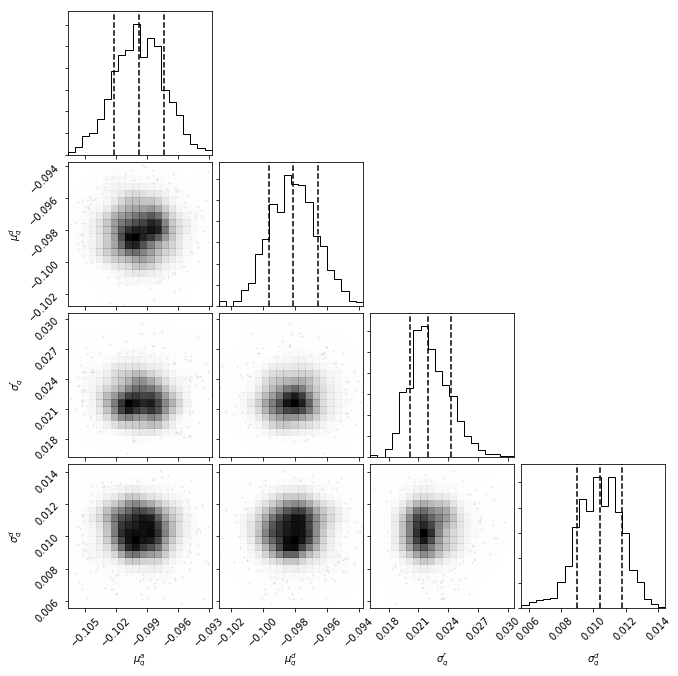

In [29]:
fig = corner.corner(pop_params_q.T,  
                labels=[r"$\mu_q^a$",r"$\mu_q^d$", 
                        r"$\sigma_q^r$",r"$\sigma_q^d$",
                        ],
                quantiles=[0.16, 0.5, 0.84],
                plot_contours=False, smooth=True)

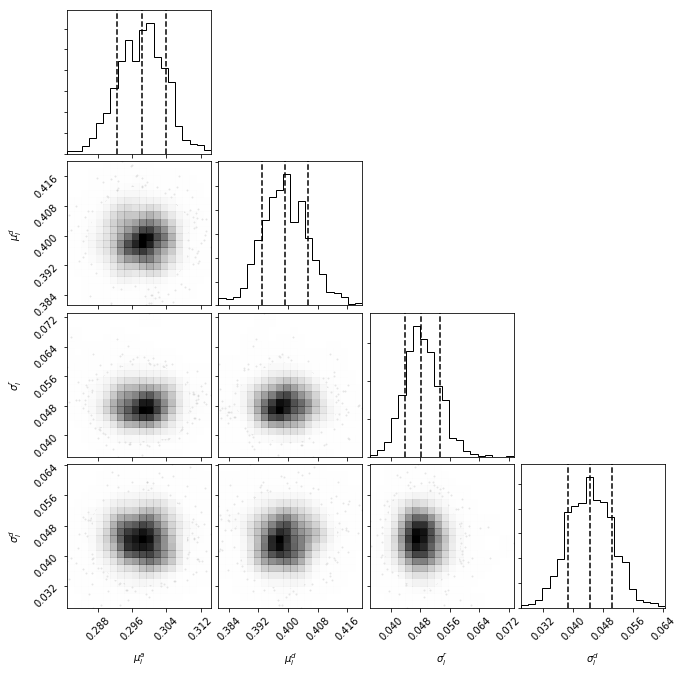

In [30]:
fig = corner.corner(pop_params_l.T,  
                labels=[r"$\mu_l^a$",r"$\mu_l^d$", 
                        r"$\sigma_l^r$",r"$\sigma_l^d$",
                        ],
                quantiles=[0.16, 0.5, 0.84],
                plot_contours=False, smooth=True)

In [31]:
print('muq ra: ', round(np.mean(muq[:,0]),2),'+/-', round(np.std(muq[:,0]),2))
print('muq dec: ', round(np.mean(muq[:,1]),2), '+/-', round(np.std(muq[:,1]),2))
print('mul ra: ', round(np.mean(mul[:,0]),2),'+/-', round(np.std(mul[:,0]),2))
print('mul dec: ', round(np.mean(mul[:,1]),2), '+/-', round(np.std(mul[:,1]),2))

print('sigmaq ra: ', round(np.mean(sigmaq[:,0]),2),'+/-', round(np.std(sigmaq[:,0]),2))
print('sigmaq dec: ', round(np.mean(sigmaq[:,1]),2), '+/-', round(np.std(sigmaq[:,1]),2))
print('sigmal ra: ', round(np.mean(sigmal[:,0]),2),'+/-', round(np.std(sigmal[:,0]),2))
print('sigmal dec: ', round(np.mean(sigmal[:,1]),2), '+/-', round(np.std(sigmal[:,1]),2))

muq ra:  -0.1 +/- 0.0
muq dec:  -0.1 +/- 0.0
mul ra:  0.3 +/- 0.01
mul dec:  0.4 +/- 0.01
sigmaq ra:  0.02 +/- 0.0
sigmaq dec:  0.01 +/- 0.0
sigmal ra:  0.05 +/- 0.0
sigmal dec:  0.04 +/- 0.01


# Now try on real data

In [32]:
def is_pos_def(x): #check covariance matrices are positive definite
    return np.all(np.linalg.eigvals(x)>0)

### Lensed QSOs

In [33]:
Nl = len(lqsoNew)

dpmra2 = lqsoNew.pmra_error**2
dpmdec2 = lqsoNew.pmdec_error**2
dpmrapmdec = lqsoNew.pmra_pmdec_corr*lqsoNew.pmra_error*lqsoNew.pmdec_error

In [34]:
lqsodata={
    'N': Nl,
    'pmhat': np.dstack([lqsoNew.pmra, lqsoNew.pmdec])[0],
    'Sig': np.reshape(np.dstack([dpmra2,dpmrapmdec, dpmrapmdec, dpmdec2]), [Nl,2,2])
}

fitlqso = sm2.sampling(data=lqsodata,  iter=2000, chains=4) 

/Users/abombrun/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [35]:
paramslqso = fitlqso.extract()

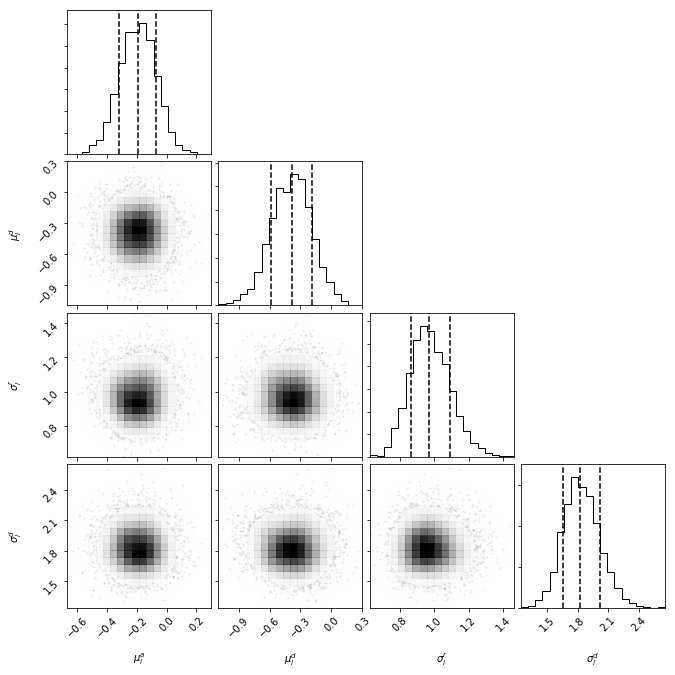

In [36]:
mul=paramslqso['mu']
sigmal=paramslqso['sigma']

pop_params_l = np.vstack([mul[:,0],mul[:,1],sigmal[:,0],sigmal[:,1]])

fig = corner.corner(pop_params_l.T,  
                labels=[r"$\mu_l^a$",r"$\mu_l^d$", 
                        r"$\sigma_l^r$",r"$\sigma_l^d$",
                        ],
                quantiles=[0.16, 0.5, 0.84],
                plot_contours=False, smooth=True)

In [37]:
print('mul ra: ', round(np.mean(mul[:,0]),2),'+/-', round(np.std(mul[:,0]),2))
print('mul dec: ', round(np.mean(mul[:,1]),2), '+/-', round(np.std(mul[:,1]),2))
print('sigmal ra: ', round(np.mean(sigmal[:,0]),2),'+/-', round(np.std(sigmal[:,0]),2))
print('sigmal dec: ', round(np.mean(sigmal[:,1]),2), '+/-', round(np.std(sigmal[:,1]),2))

mul ra:  -0.2 +/- 0.12
mul dec:  -0.39 +/- 0.2
sigmal ra:  0.98 +/- 0.12
sigmal dec:  1.84 +/- 0.18


### QSO's sample

In [38]:
allwisenew2 = allwiseQSO.sample(n=Nl)
Nq = len(allwisenew2)

In [39]:
dpmra2 = allwisenew2.pmra_error**2
dpmdec2 = allwisenew2.pmdec_error**2
dpmrapmdec = allwisenew2.pmra_pmdec_corr*allwisenew2.pmra_error*allwisenew2.pmdec_error

In [40]:
qsodata={
    'N': Nq,
    'pmhat': np.dstack([allwisenew2.pmra, allwisenew2.pmdec])[0],
    'Sig': np.reshape(np.dstack([dpmra2,dpmrapmdec, dpmrapmdec, dpmdec2]), [Nq,2,2])
}

fitqso = sm2.sampling(data=qsodata,  iter=2000, chains=4) 

/Users/abombrun/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [41]:
paramsqso = fitqso.extract()

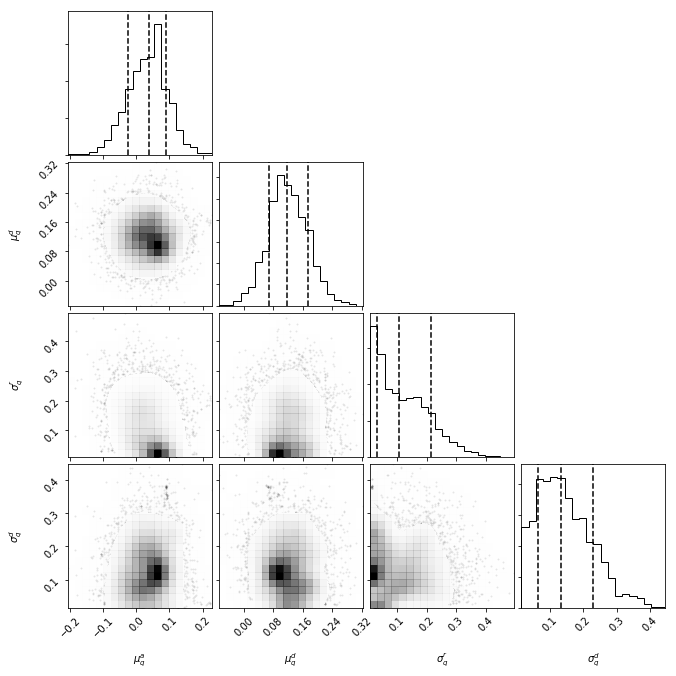

In [42]:
muq=paramsqso['mu']
sigmaq=paramsqso['sigma']

pop_params_q = np.vstack([muq[:,0],muq[:,1],sigmaq[:,0],sigmaq[:,1]])

fig = corner.corner(pop_params_q.T,  
                labels=[r"$\mu_q^a$",r"$\mu_q^d$", 
                        r"$\sigma_q^r$",r"$\sigma_q^d$",
                        ],
                quantiles=[0.16, 0.5, 0.84],
                plot_contours=False, smooth=True)

In [43]:
print('muq ra: ', round(np.mean(muq[:,0]),2),'+/-', round(np.std(muq[:,0]),2))
print('muq dec: ', round(np.mean(muq[:,1]),2), '+/-', round(np.std(muq[:,1]),2))
print('sigmaq ra: ', round(np.mean(sigmaq[:,0]),2),'+/-', round(np.std(sigmaq[:,0]),2))
print('sigmaq dec: ', round(np.mean(sigmaq[:,1]),2), '+/-', round(np.std(sigmaq[:,1]),2))

muq ra:  0.03 +/- 0.06
muq dec:  0.12 +/- 0.05
sigmaq ra:  0.12 +/- 0.09
sigmaq dec:  0.14 +/- 0.08
